In [2]:
# 정밀도: 72~82
import FinanceDataReader as fdr

sp500 = fdr.StockListing("S&P500")
sp500.head()

,Symbol,Name,Sector,Industry
0,MMM,3M,Industrials,Industrial Conglomerates
1,AOS,A. O. Smith,Industrials,Building Products
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment
3,ABBV,AbbVie,Health Care,Biotechnology
4,ACN,Accenture,Information Technology,IT Consulting & Other Services


In [10]:
def make_rsi(close, periods = 14):
    delta = close.diff()
    gain = delta.where(delta > 0, 0).ewm(alpha = 1/periods, min_periods = periods, adjust = False).mean()
    loss = -delta.where(delta < 0, 0).ewm(alpha = 1/periods, min_periods = periods, adjust = False).mean()
    rs = gain / (loss + 1e-9)
    return 100 - (100 / (1 + rs))

df = fdr.DataReader("AAPL")
make_rsi(df['Close'])

1980-12-12          NaN
1980-12-15          NaN
1980-12-16          NaN
1980-12-17          NaN
1980-12-18          NaN
                ...    
2025-06-26    49.621039
2025-06-27    49.770113
2025-06-30    56.806887
2025-07-01    60.653082
2025-07-02    66.289029
Name: Close, Length: 11229, dtype: float64

In [14]:
from tqdm import tqdm
import pandas as pd

sp500_dic = {}
for i in tqdm(range(len(sp500))):
    try:
        row = sp500.iloc[i]
        symbol = row['Symbol']
        name = row['Name']
        df = fdr.DataReader(symbol)
        df['RSI'] = make_rsi(df['Close'])
        df['Change'] = df['Close'].pct_change() * 100
        df = df.dropna()
        sp500_dic[symbol] = [name, df]
    except:
        continue

100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [05:34<00:00,  1.51it/s]


In [20]:
# 왜 특성을 추가해도 성능이 비슷한가? 왜 항상 좋게 나오는가?
# 데이터 누수 문제
year = 2017
period = 40

train_x = []
train_y = []
test_x = []
test_y = []

for symbol in sp500_dic:
    
    name = sp500_dic[symbol][0]
    df = sp500_dic[symbol][1].copy()[['Close', 'Change', 'RSI']]

    train = df[df.index.year < year].values
    test = df[df.index.year >= year].values

    for i in range(len(train) - period):
        a = train[i, 1:]
        before = train[i, 0]
        after = train[i+period, 0]
        b = (after-before)/before*100 >= 5
        train_x.append(a)
        train_y.append(b)

    for i in range(len(test) - period):
        a = test[i, 1:]
        before = test[i, 0]
        after = test[i+period, 0]
        b = (after-before)/before*100 >= 5
        test_x.append(a)
        test_y.append(b)

In [21]:
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(train_x, train_y)

pred = model.predict(test_x)

report = classification_report(test_y, pred)
print(report)

              precision    recall  f1-score   support

       False       0.62      1.00      0.76    632592
        True       0.50      0.01      0.01    394302

    accuracy                           0.62   1026894
   macro avg       0.56      0.50      0.39   1026894
weighted avg       0.57      0.62      0.47   1026894



In [25]:
from scipy.stats import norm

sigma = 4
A = norm.cdf(-sigma)

n = 100000

print(f"{n}번 시행했을때, 약 {n * A}건")

100000번 시행했을때, 약 3.1671241833119863건


In [26]:
2 ** 530 * 0.4 ** 470

3.2665824620458253e-28

In [27]:
(4/3) ** 470 * (4/5) ** 530

22850689.634863265

In [29]:
(250 * 0.7) ** (1/2)

13.228756555322953

In [30]:
50 / 13

3.8461538461538463

In [32]:
(250 * (3/4)) ** (1/2)

13.693063937629153

In [33]:
# 켈리 방정식
# p : 승리확률, b : 배당률(1000원 건다 - 2000원 순수익 b = 2)
def kelly1(p, b):
    q = 1 - p
    result = (b * p - q) / b
    return max(0, result)

kelly1(0.55, 1)

0.10000000000000009

In [38]:
def kelly2(p, win_rate, loss_rate):
    q = 1 - p
    
    if (p * win_rate) <= (q * loss_rate):
        return 0

    A = p * win_rate - q * loss_rate
    B = win_rate * loss_rate

    result = A / B
    return max(0, result)

# 승률 60%, 이기면 20%, 지면 10%를 잃는다.
kelly2(0.35, 0.2, 0.1);

0.24999999999999947

In [39]:
# 2번
kelly1(0.40, 2.5)

0.16

In [40]:
# 3번: 이길 확률 30%, 2배
kelly1(0.30, 2)

0

In [41]:
# 4번: 승률 50% 이기면 15%, 지면 15%
kelly2(0.5, 0.15, 0.15)

0

In [42]:
# 5번: 승률 45%, 이기면 30%, 지면 10%
kelly2(0.45, 0.3, 0.1)

2.666666666666667

In [43]:
# 6번: 승률 70%, 이기면 10%, 지면 30%
kelly2(0.7, 0.1, 0.3)

0

In [45]:
import FinanceDataReader as fdr

stocks = ['TSLA', "AAPL", "NVDA"]

df = fdr.DataReader(stocks).dropna()
df

,TSLA,AAPL,NVDA
2010-06-29,1.592667,7.698982,0.240238
2010-06-30,1.588667,7.559529,0.234048
2010-07-01,1.464000,7.467864,0.237945
2010-07-02,1.280000,7.421580,0.234965
2010-07-06,1.074000,7.472374,0.232444
...,...,...,...
2025-06-26,325.779999,201.000000,155.020004
2025-06-27,323.630005,201.080002,157.750000
2025-06-30,317.660004,205.169998,157.990005
2025-07-01,300.709991,207.820007,153.300003


In [47]:
# 각 종목별로 일간 수익률
daily_ret = df.pct_change()
daily_ret

,TSLA,AAPL,NVDA
2010-06-29,NaN,NaN,NaN
2010-06-30,-0.002511,-0.018113,-0.025763
2010-07-01,-0.078473,-0.012126,0.016650
2010-07-02,-0.125683,-0.006198,-0.012524
2010-07-06,-0.160937,0.006844,-0.010731
...,...,...,...
2025-06-26,-0.005404,-0.002778,0.004601
2025-06-27,-0.006600,0.000398,0.017611
2025-06-30,-0.018447,0.020340,0.001521
2025-07-01,-0.053359,0.012916,-0.029685


In [50]:
# 종목별 연간 평균 수익률
annual_ret = daily_ret.mean() * 252
annual_ret

TSLA    0.521155
AAPL    0.261442
NVDA    0.538328
dtype: float64

In [66]:
# 위험(리스크) : 변동성이 크다. -> 공분산
import numpy as np

study = [2, 3, 5, 6, 8]
scores = [65, 70, 75, 80, 90]

mean_study = np.mean(study)
mean_scores = np.mean(scores)

study2 = [i - mean_study for i in study]
scores2 = [i - mean_scores for i in scores]

A = sum([i * j for i, j in zip(study2, scores2)])

result = A / (len(study2) - 1)

A = np.array([study, scores])
B = np.cov(A)

var_study = B[0,0]
var_scores = B[1,1]
var = B[0,1]

std_study = np.sqrt(var_study)
std_scores = np.sqrt(var_scores)

corr = B / (std_study * std_scores)
corr

array([[0.24823703, 0.99077059],
       [0.99077059, 4.0284079 ]])

In [69]:
daily_cov = daily_ret.cov()
daily_cov

,TSLA,AAPL,NVDA
TSLA,0.001341,0.000242,0.000396
AAPL,0.000242,0.000317,0.000250
NVDA,0.000396,0.000250,0.000842


In [71]:
# 연간 리스크
annual_cov = daily_cov * 252
annual_cov

,TSLA,AAPL,NVDA
TSLA,0.337954,0.060861,0.099804
AAPL,0.060861,0.079802,0.063029
NVDA,0.099804,0.063029,0.212301


In [86]:
import pandas as pd

total = []

for n in range(10000):
    
    weights = np.random.random(len(stocks))
    weights /= np.sum(weights)

    returns = np.dot(weights, annual_ret)
    risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights)))
    sharpe_ratio = (returns - 0.03) / risk

    total.append([returns, risk, sharpe_ratio] + list(weights))

df = pd.DataFrame(total, columns = ['Returns', 'Risk', 'Sharpe'] + stocks)
df

,Returns,Risk,Sharpe,TSLA,AAPL,NVDA
0,0.465101,0.366989,1.185596,0.373331,0.241313,0.385356
1,0.435328,0.343929,1.178524,0.339362,0.350945,0.309693
2,0.422715,0.325414,1.206818,0.220299,0.403884,0.375817
3,0.460526,0.433905,0.992213,0.656140,0.240296,0.103564
4,0.422956,0.395444,0.993708,0.570509,0.381292,0.048199
...,...,...,...,...,...,...
9995,0.410420,0.368241,1.033072,0.492806,0.431388,0.075806
9996,0.454700,0.407919,1.041137,0.581065,0.265992,0.152943
9997,0.463653,0.361365,1.200041,0.117737,0.262394,0.619869
9998,0.377885,0.298325,1.166128,0.139285,0.570815,0.289900


In [87]:
max_sharpe = df[df['Sharpe'] == df['Sharpe'].max()]
max_sharpe

,Returns,Risk,Sharpe,TSLA,AAPL,NVDA
4572,0.459902,0.352764,1.218668,0.220509,0.269568,0.509923


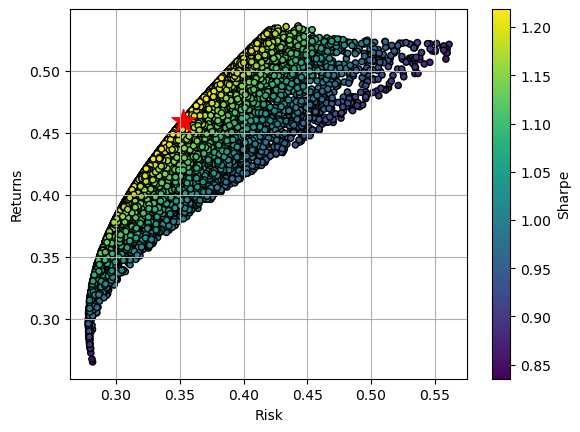

In [88]:
import matplotlib.pyplot as plt

df.plot.scatter(x = 'Risk', y = 'Returns', grid = True,
                cmap = 'viridis', c = "Sharpe", edgecolor = 'k')

plt.scatter(x = max_sharpe['Risk'], y = max_sharpe['Returns'],
            c = 'r', marker = '*', s = 300)

plt.show()